# Introduction

This is a solution to the fake news classification problem based on the "a Million News Headline" and the "Fake News Net" dataset.We use the GloVe word vectors to facilitate the embedding of new headlines, and train several classifiers to distinguish between real and fake news headlines.

# Preparation

Import packages as needed:

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk
from nltk.corpus import stopwords
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


Define a function to clean text. This removes irregular symbols and stop words.

In [2]:
def clean_text(text):
    # Remove special characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Convert text to lowercase and tokenize words
    words = text.lower().split()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Join words back into a single string
    cleaned_text = ' '.join(words)
    
    return cleaned_text



Data preprocessing: we use "a Million News Headlines" as real headlines (with label 1), and the fake ones in "Fake News Net" as fake headlines (with label 0).

In [3]:
# Load datasets
fake_politifact = pd.read_csv('politifact_fake.csv')
fake_gossipcop = pd.read_csv('gossipcop_fake.csv')
abcnews = pd.read_csv('abcnews-date-text.csv')

# Assign labels: 0 for fake news, 1 for real news
fake_politifact['label'] = 0
fake_gossipcop['label'] = 0
abcnews['label'] = 1

# Preprocess the dataset
abcnews = abcnews.sample(5755)  # Sample 5,755 headlines to balance the two classes
abcnews.rename(columns={'headline_text': 'title'}, inplace=True)  # Rename the column to match other datasets
abcnews['cleaned_title'] = abcnews['title'].apply(clean_text)  # Clean the headlines

# Concatenate datasets
data = pd.concat([fake_politifact, abcnews, fake_gossipcop], axis=0, ignore_index=True)
data['cleaned_title'] = data['title'].apply(clean_text)

In [4]:
# Split data into training and testing sets (80% train, 20% test)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

Let's have a look at the data.

In [5]:
train_data.shape

(9208, 7)

In [6]:
train_data.head()


,id,news_url,title,tweet_ids,label,publish_date,cleaned_title
5551,NaN,NaN,restraint needed in tibet but no olympic boycott,NaN,1,20080325.0,restraint needed tibet olympic boycott
6569,gossipcop-2870728999,people.com/health/celebrities-told-to-lose-weight,13 Celebrities Who Were Told to Lose Weight (Y...,NaN,0,NaN,celebrities told lose weight yep really
2152,NaN,NaN,higher peak prices could cut power bills overall,NaN,1,20140707.0,higher peak prices could cut power bills overall
6464,gossipcop-3807603124,www.lifeandstylemag.com/posts/gigi-hadid-zayn-...,Gigi Hadid Begs Zayn Malik to Quit Touring Due...,886209901948620800\t886211348400656384\t886309...,0,NaN,gigi hadid begs zayn malik quit touring due se...
3652,NaN,NaN,metgasco agm,NaN,1,20131029.0,metgasco agm


In [7]:
test_data.shape

(2302, 7)

In [8]:
test_data.head()

,id,news_url,title,tweet_ids,label,publish_date,cleaned_title
4630,NaN,NaN,interview with bob brown,NaN,1,20111123.0,interview bob brown
2802,NaN,NaN,senate sitting hears carbon tax fears,NaN,1,20110803.0,senate sitting hears carbon tax fears
7524,gossipcop-595491190,www.celebsnow.co.uk/celebrity-news/brad-pitt-s...,Is Brad Pitt secretly dating Sienna Miller fol...,880044110496890880\t880045258058252295\t880045...,0,NaN,brad pitt secretly dating sienna miller follow...
9679,gossipcop-789623646,indianexpress.com/article/entertainment/hollyw...,Priyanka Chopra not attending Oscars 2017 with...,835835678973796352\t835836092435709954\t835841...,0,NaN,priyanka chopra attending oscars mick jagger r...
10018,gossipcop-5001654773,hollywoodlife.com/2017/02/16/jared-leto-angeli...,Jared Leto & Angelina Jolie: He Regrets Lettin...,832405673971376128\t832405767261032448\t832405...,0,NaN,jared leto angelina jolie regrets letting slip...


Load GloVe, a publicly available set of pre-trained word vectors:

In [9]:
def load_glove_vectors(glove_file):
    word_vectors = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            word_vectors[word] = vector
    return word_vectors

glove_vectors = load_glove_vectors('glove.6B.50d.txt')


The sentence vector is calculated by the tfidf-weighted average of its words.

In [10]:
def weighted_average_vectors(docs, vectorizer, word_vectors, dim=50):
    # Calculate the tf-idf weights for the given documents
    tfidf_matrix = vectorizer.fit_transform(docs)

    # Initialize an empty matrix to store the weighted average vectors
    weighted_vectors = np.zeros((len(docs), dim))

    # Iterate through the documents and compute the weighted average vector for each
    for i, doc in enumerate(docs):
        words = doc.split()
        weighted_sum = np.zeros(dim)
        total_weight = 0

        for word in words:
            if word in word_vectors and word in vectorizer.vocabulary_:
                vector = word_vectors[word]
                weight = tfidf_matrix[i, vectorizer.vocabulary_[word]]
                weighted_sum += weight * vector
                total_weight += weight

        if total_weight != 0:
            weighted_vectors[i] = weighted_sum / total_weight

    return weighted_vectors


In [11]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train = weighted_average_vectors(train_data['cleaned_title'], vectorizer, glove_vectors)
X_test = weighted_average_vectors(test_data['cleaned_title'], vectorizer, glove_vectors)

y_train = train_data['label'].values
y_test = test_data['label'].values


# Classifiers

Autoencoder

In [12]:
def create_autoencoder(input_dim, encoding_dim, hidden_layers):
    # Encoder
    encoder_input = Input(shape=(input_dim,))
    encoder_layers = [Dense(hidden_layers[0], activation='relu')(encoder_input)]

    for layer_size in hidden_layers[1:]:
        encoder_layers.append(Dense(layer_size, activation='relu')(encoder_layers[-1]))

    # Encoded representation
    encoded = Dense(encoding_dim, activation='relu')(encoder_layers[-1])

    # Decoder
    decoder_layers = [Dense(hidden_layers[-1], activation='relu')(encoded)]

    for layer_size in reversed(hidden_layers[:-1]):
        decoder_layers.append(Dense(layer_size, activation='relu')(decoder_layers[-1]))

    # Reconstruction
    decoder_output = Dense(input_dim, activation='linear')(decoder_layers[-1])

    # Build the autoencoder model
    autoencoder = Model(encoder_input, decoder_output)
    return autoencoder


In [13]:
input_dim = X_train.shape[1]
encoding_dim = 15
hidden_layers = [35, 20]

autoencoder = create_autoencoder(input_dim, encoding_dim, hidden_layers)
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 dense (Dense)               (None, 35)                1785      
                                                                 
 dense_1 (Dense)             (None, 20)                720       
                                                                 
 dense_2 (Dense)             (None, 15)                315       
                                                                 
 dense_3 (Dense)             (None, 20)                320       
                                                                 
 dense_4 (Dense)             (None, 35)                735       
                                                                 
 dense_5 (Dense)             (None, 50)                1800  

In [14]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
loss = MeanSquaredError()
autoencoder.compile(optimizer=optimizer, loss=loss)

# Train the model
real_headlines = X_train[y_train == 1]  # filter real news headlines
epochs = 100
batch_size = 32
autoencoder.fit(real_headlines, real_headlines, epochs=epochs, batch_size=batch_size, validation_split=0.1)


Epoch 1/100
130/130 [==============================] - 2s 9ms/step - loss: 0.1600 - val_loss: 0.1128
Epoch 2/100
130/130 [==============================] - 0s 3ms/step - loss: 0.1043 - val_loss: 0.0979
Epoch 3/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0910 - val_loss: 0.0872
Epoch 4/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0817 - val_loss: 0.0796
Epoch 5/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0759 - val_loss: 0.0757
Epoch 6/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0725 - val_loss: 0.0729
Epoch 7/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0698 - val_loss: 0.0705
Epoch 8/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0680 - val_loss: 0.0695
Epoch 9/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0670 - val_loss: 0.0682
Epoch 10/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0658 - val_lo

130/130 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0530
Epoch 82/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0532
Epoch 83/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0528
Epoch 84/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0530
Epoch 85/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0527
Epoch 86/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0529
Epoch 87/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0528
Epoch 88/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0529
Epoch 89/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0528
Epoch 90/100
130/130 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 

In [15]:
# Reconstruct headlines in the test set
X_test_reconstructed = autoencoder.predict(X_test)

# Calculate the reconstruction errors
reconstruction_errors = np.mean((X_test - X_test_reconstructed)**2, axis=1)


72/72 [==============================] - 0s 2ms/step


In [16]:
from sklearn.metrics import confusion_matrix

def find_optimal_threshold(errors, y_true):
    min_diff = float('inf')
    optimal_threshold = 0

    for threshold in np.linspace(errors.min(), errors.max(), num=1000):
        y_pred = (errors > threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fpr = fp / (fp + tn)  # False Positive Rate
        fnr = fn / (fn + tp)  # False Negative Rate

        diff = abs(fpr - fnr)

        if diff < min_diff:
            min_diff = diff
            optimal_threshold = threshold

    return optimal_threshold

threshold = find_optimal_threshold(reconstruction_errors, y_test)


In [17]:
y_pred = (reconstruction_errors > threshold).astype(int)


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Autoencoder Classifier Metrics:\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}")



Autoencoder Classifier Metrics:
Accuracy: 0.5695047784535187
Precision: 0.5720448662640207
Recall: 0.572538860103627
F1 Score: 0.5722917565817869


Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model with an increased number of iterations
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg.predict(X_test)

# Calculate metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print(f"Logistic Regression Metrics:\nAccuracy: {accuracy_log_reg}\nPrecision: {precision_log_reg}\nRecall: {recall_log_reg}\nF1 Score: {f1_log_reg}")


Logistic Regression Metrics:
Accuracy: 0.8857515204170286
Precision: 0.8942731277533039
Recall: 0.8765112262521589
F1 Score: 0.8853030963802879


Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

# Train the random forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Calculate metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Random Forest Metrics:\nAccuracy: {accuracy_rf}\nPrecision: {precision_rf}\nRecall: {recall_rf}\nF1 Score: {f1_rf}")


Random Forest Metrics:
Accuracy: 0.9018245004344049
Precision: 0.898972602739726
Recall: 0.9067357512953368
F1 Score: 0.9028374892519347


MLP

In [21]:
from sklearn.neural_network import MLPClassifier

#Train
mlp = MLPClassifier(solver='sgd', learning_rate = "adaptive", learning_rate_init = 0.1, alpha=1e-5,hidden_layer_sizes=(64,32), random_state=1,max_iter=500)
mlp.fit(X_train, y_train)

#Predict
y_pred_mlp = mlp.predict(X_test)

# Calculate metrics
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

print(f"MLP:\nAccuracy: {accuracy_mlp}\nPrecision: {precision_mlp}\nRecall: {recall_mlp}\nF1 Score: {f1_mlp}")

MLP:
Accuracy: 0.9061685490877498
Precision: 0.9212880143112702
Recall: 0.8894645941278065
F1 Score: 0.9050966608084358


SVM

In [22]:
from sklearn.svm import LinearSVC

#Train
svc = LinearSVC(penalty = "l1", loss="squared_hinge",dual=False, max_iter = 10000, tol = 0.001)
svc.fit(X_train, y_train)

#Predict
y_pred_svc = svc.predict(X_test)

# Calculate metrics
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)

print(f"SVM:\nAccuracy: {accuracy_svc}\nPrecision: {precision_svc}\nRecall: {recall_svc}\nF1 Score: {f1_svc}")

SVM:
Accuracy: 0.8874891398783666
Precision: 0.8981399468556245
Recall: 0.8756476683937824
F1 Score: 0.8867512024486226


Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

#Train
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

#Predict
y_pred_dt = dt.predict(X_test)

# Calculate metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print(f"Decision Tree:\nAccuracy: {accuracy_dt}\nPrecision: {precision_dt}\nRecall: {recall_dt}\nF1 Score: {f1_dt}")

Decision Tree:
Accuracy: 0.8284100781928757
Precision: 0.840929401251117
Recall: 0.812607944732297
F1 Score: 0.826526130873957


KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

#Train
knn = KNeighborsClassifier(n_neighbors=5, metric="cosine")
knn.fit(X_train, y_train)

#Predict
y_pred_knn = knn.predict(X_test)

# Calculate metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

print(f"KNN:\nAccuracy: {accuracy_knn}\nPrecision: {precision_knn}\nRecall: {recall_knn}\nF1 Score: {f1_knn}")

KNN:
Accuracy: 0.8935708079930496
Precision: 0.9168949771689497
Recall: 0.8670120898100173
F1 Score: 0.8912561029738127


AdaBoost based on Random Forest

In [25]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

#Train
rf = RandomForestClassifier(max_depth=10, random_state=0)
ada = AdaBoostClassifier(estimator = rf, n_estimators=10)
ada.fit(X_train, y_train)

#Predict
y_pred_ada = ada.predict(X_test)

# Calculate metrics
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)

print(f"Decision Tree:\nAccuracy: {accuracy_ada}\nPrecision: {precision_ada}\nRecall: {recall_ada}\nF1 Score: {f1_ada}")

Decision Tree:
Accuracy: 0.9183318853171155
Precision: 0.9269366197183099
Recall: 0.9093264248704663
F1 Score: 0.9180470793374018


# Results

We visualize our results using the figure below.

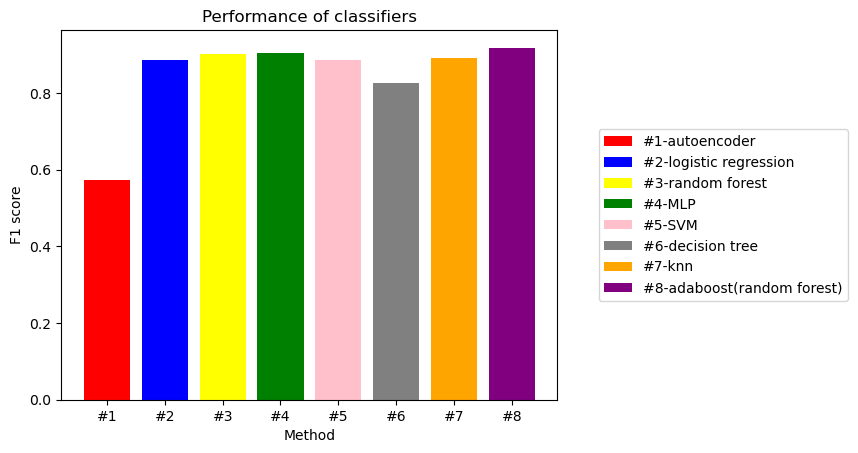

In [26]:
import matplotlib.pyplot as plt
temp = ["#1","#2","#3","#4","#5","#6","#7","#8"]
x = ["#1-autoencoder","#2-logistic regression","#3-random forest","#4-MLP","#5-SVM","#6-decision tree","#7-knn","#8-adaboost(random forest)"]
y = [f1,f1_log_reg,f1_rf,f1_mlp,f1_svc,f1_dt,f1_knn,f1_ada]
plt.bar(temp,y,label=x, color=np.array(["red","blue","yellow","green","pink","grey","orange","purple"]))
plt.xlabel('Method')
plt.ylabel('F1 score')
plt.title('Performance of classifiers')
plt.legend(loc="center right",bbox_to_anchor=(1.6, 0.5))
plt.show()